In [1]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, order_poly_ZNE, order_poly_instance, converge_ZNE_order, converge_ZNE_loocv

from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from functions_util import cetina_thermal_exp, cetina_envelope_exp,calibrate_sim_Omegas
from samplers_util import thermal_rejection
from tqdm import tqdm

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit

#Add util to the path
import sys
sys.path.append('../util')
from samplers_util import thermal_rejection
from fitting_functions_ZNE import third_no_first_ZNE, converge_ZNE_loocv
import matplotlib as mpl


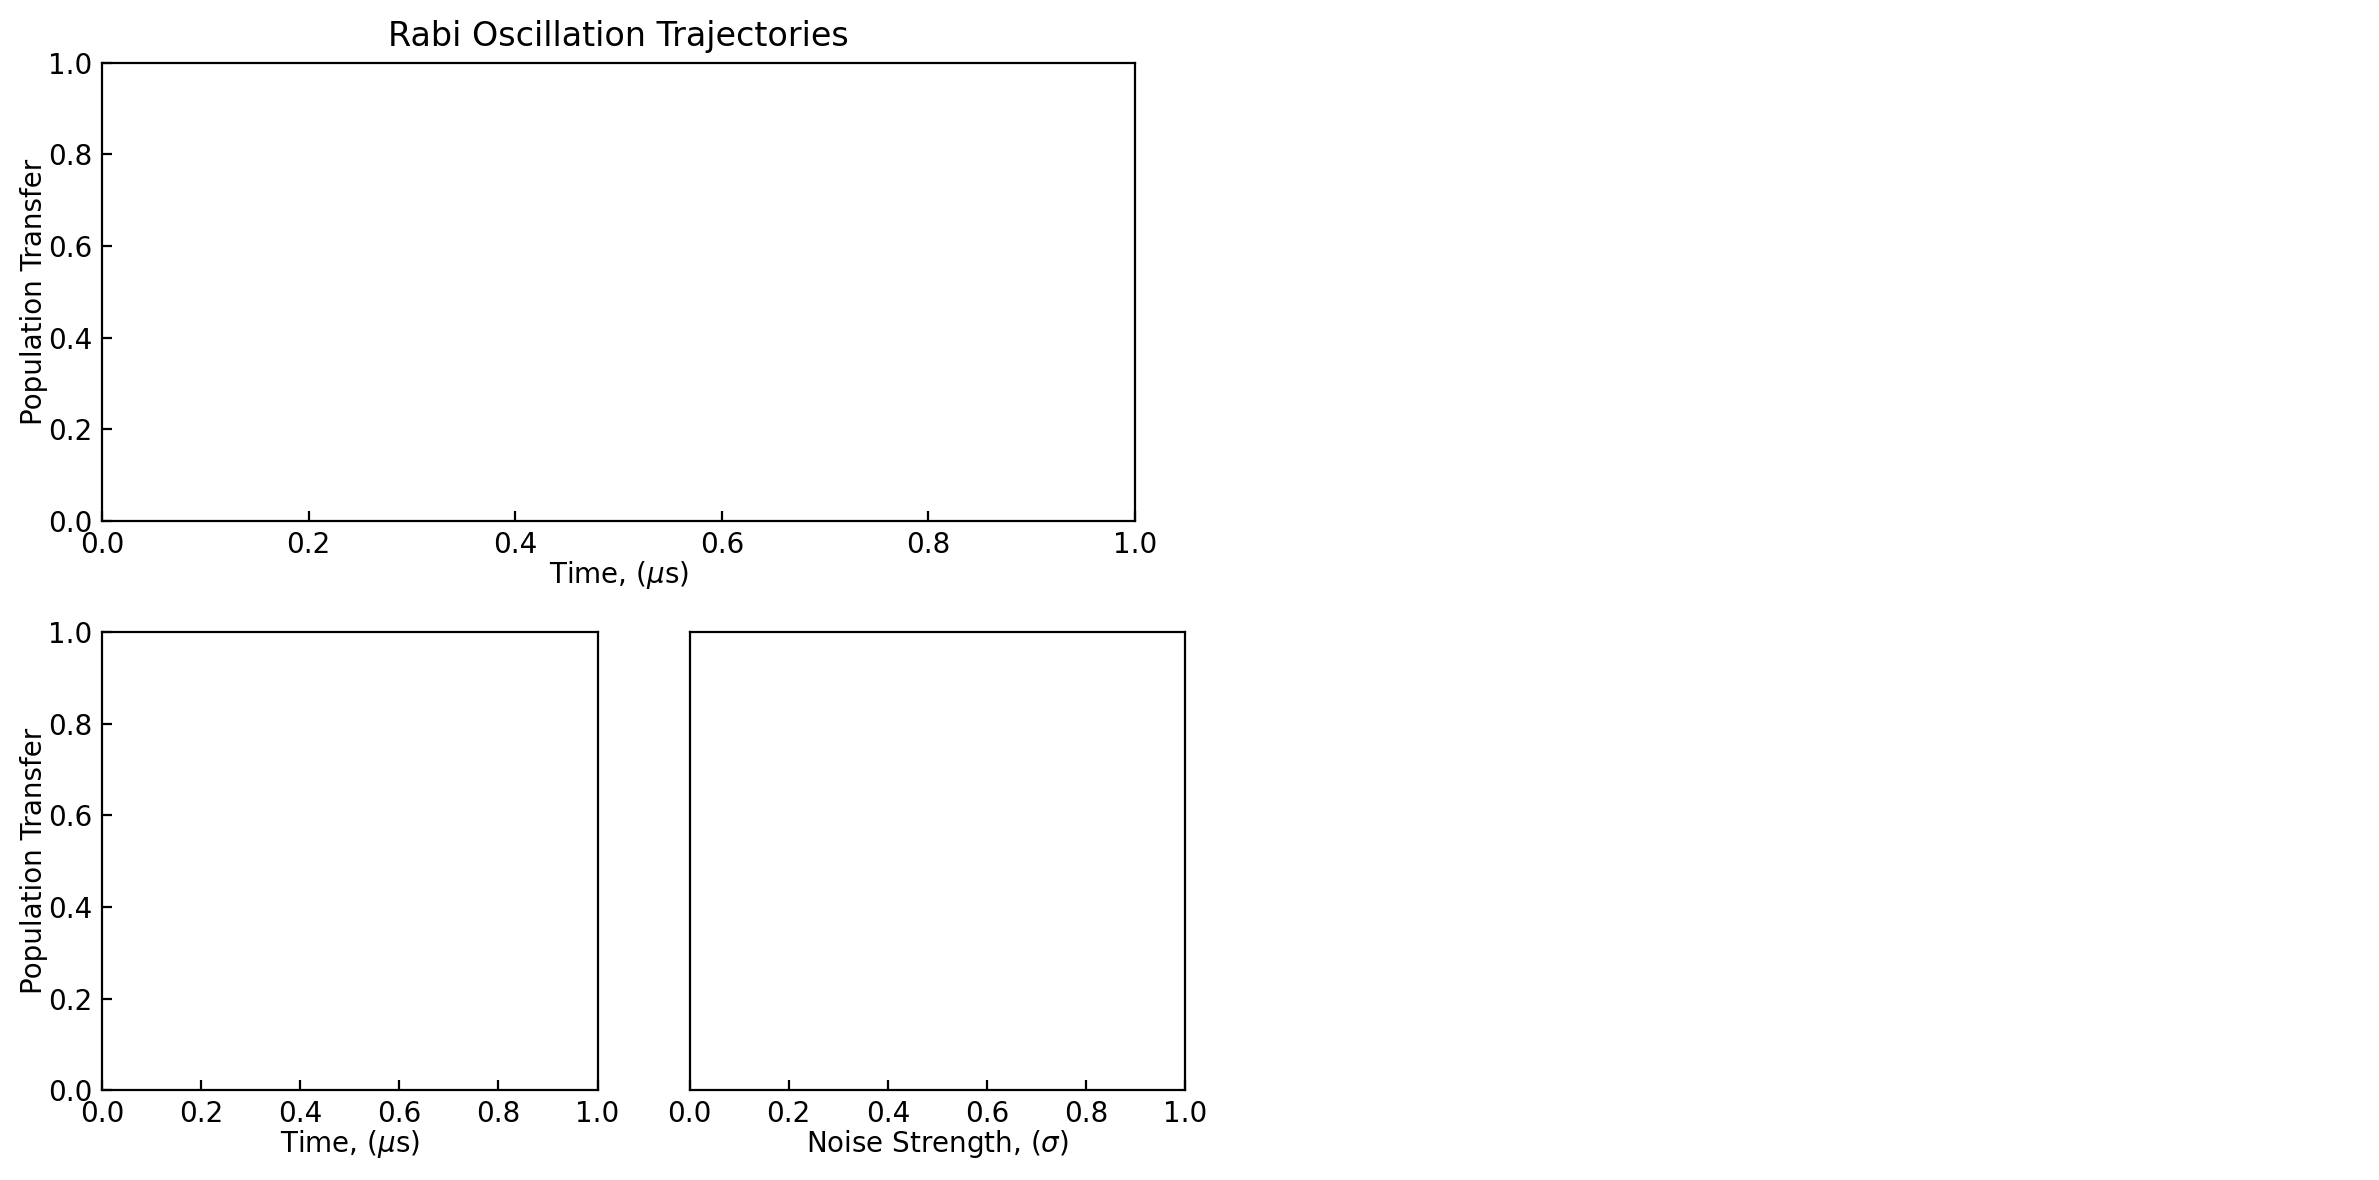

In [3]:
"""Figure includes Rabi oscillations for Gaussian noise, and regions for Rydberg and trapped ion error mechanisms. 
|---|--|
|   |  |
|-|-|--|
| | |  |
|-|-|--|
"""

columns = 2
rows = 2
scol=(3+3/8) #single column width of PRL,
dcol=2*scol # double column,
size_col = scol*columns#[scol, dcol][columns-1]
size_row = scol*rows#scol, dcol][rows-1]

fullwidth=6.3,
from matplotlib import cm
gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,


mpl.rcParams.update({
    "ytick.direction": "in",
    "xtick.direction": "in",
    "axes.labelpad": 0,
    "font.size": 10,
    "legend.frameon": True,
    "figure.dpi":200,
    "figure.figsize": [size_col, size_row * gr],
    #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
})
#Create a matplotlib subplots in the layout above
fig = plt.figure(figsize=(12, 6))
ax_a = fig.add_subplot(221)
ax_bi = fig.add_subplot(245)
ax_bii = fig.add_subplot(246)
ax_c = fig.add_subplot(222)
ax_d = fig.add_subplot(224)
#don't display the ax_c and ax_d plots
ax_c.axis('off')
ax_d.axis('off')
#Make the ticks on ax_bii on the  right instead of left:
#ax_bii.yaxis.tick_right()
#turn off the 

#Axis a
ax_a.set_xlabel(r'Time, ($\mu$s)')
ax_a.set_title('Rabi Oscillation Trajectories')
ax_a.set_ylabel('Population Transfer')
#Axis b (i)
ax_bi.set_xlabel(r'Time, ($\mu$s)')
ax_bii.set_xlabel(r'Noise Strength, ($\sigma$)')
ax_bi.set_ylabel('Population Transfer')
ax_bii.set_yticks([])

#ax_bii.set_ylabel('Population Transfer')
#Set the ax_bii y-axis equal to the ax_bi y-axis
#ax_bii.set_ylim(ax_bi.get_ylim())


fig.tight_layout()
#plt.show()


In [4]:
#Reading in Or Data:
#Data files:
#Output data: 
#shape = heating, time, qubit
def exp_fit(t, A, B, C, D):
    return A*np.exp(-B*t)*np.cos(C*t+D) + A
def rabi_fit(t, Omega):
    return (1-np.cos(Omega*t))/2
KHz = 1e3
micro = 1e-6
Omega =  2210*KHz
sigma = .1*Omega #MODIFIED
delta_samples = 1000
nano = 1e-9
n_bar = 800
time_points = 100


t = np.linspace(0, 40*micro, time_points)
def Rabi(Omega_array, t_array):
    output = np.zeros((len(Omega_array), len(t_array)))
    for i, Omega in enumerate(Omega_array):
        output[i] = (1-np.cos(Omega*t_array/2))/2
    return output


NORMALIZER = 280/0.15

def sample_thermal_n(n_bar:int):
    n_max = 20*n_bar
    
    n_bar = int(n_bar*NORMALIZER)
    n_max = int(n_max*NORMALIZER)
    if n_bar == 0:
        return 0
    #print(n_bar, n_max)
    def pr_n(n: int, n_bar:int):
        """Returns the probability of sampling the value $n$ from the thermal distribution"""
        return (1/(1 + n_bar)) * np.power((n_bar/(1 + n_bar)),n)
        return (1 - n_bar) * n_bar**n
    pr_0 = pr_n(0, n_bar)
    
    n = np.random.randint(0, n_max)
    r = np.random.uniform(0, pr_0)
    pr_n_sample = pr_n(n, n_bar)
    while r > pr_n_sample:
        n = np.random.randint(0, n_max)
        r = np.random.uniform(0, pr_0)
        pr_n_sample = pr_n(n, n_bar)
    return n/NORMALIZER - n_bar/NORMALIZER

def sample_normal(theta:float):
    
    return np.random.normal(0, theta)
    #return n
    
#Plotting the first Omega:
Omega_test = 1648442
theta_alpha = -42409
Omega_test = 3750000
times = np.linspace(0, 10*micro, time_points)
#times = times*micro
n_bar = 0.05
delta_thermal = np.array([sample_thermal_n(n_bar) for i in range(delta_samples)])
P_thermal = Rabi(Omega_test*(1+delta_thermal), times)
P_avg_thermal = np.mean(P_thermal, axis=0)

times_dense = np.linspace(0, 10*micro, time_points)
times_dense_plotting = np.linspace(0, 10, time_points)
P_thermal_dense = Rabi(Omega_test*(1+delta_thermal), times_dense)
#print(P_thermal_dense.shape)
P_avg_thermal_dense = np.mean(P_thermal_dense, axis=0)
#print(P_avg_thermal_dense)

def gen_noisy_rabi(Omega, theta, delta_samples):
    delta_thermal = np.array([sample_thermal_n(theta) for i in range(delta_samples)])
    P_thermal = Rabi(Omega*(1+delta_thermal), times_dense)
    #print(P_thermal.shape)
    P_avg_thermal = np.mean(P_thermal, axis=0)
    P_std_thermal = np.std(P_thermal, axis=0)/np.sqrt(delta_samples)
    return P_avg_thermal, P_std_thermal

In [38]:

for i in range(0,P_thermal_dense.shape[0], 10):
    ax_a.plot(times_dense_plotting, P_thermal_dense[i,:], 'b', alpha=0.02, zorder=-1) 
ax_a.plot(times_dense_plotting, P_avg_thermal_dense, 'b', alpha=0.5, zorder=-1, label='Noisy Trajectories')
ax_a.plot(times_dense_plotting, P_avg_thermal_dense, c='k', label='Averaged Expectation')


ZNE_points = np.array([0, 1, 1.1, 1.3, 1.6, 2, 2.5, 3, 3.5])
cm_subsection = np.linspace(0.2, 1.0, len(ZNE_points) )
Reds = [ cm.Reds(x) for x in cm_subsection ]
cmap = LinearSegmentedColormap.from_list('name', Reds)
print(Reds)
baseline = 0.1  # MODIFIED
#get a blue to red colormap
colors = Reds#cmap(np.linspace(0, 1, len(ZNE_points)))
#print(colors)
#Add a color bar:
colorbar = plt.cm.ScalarMappable(cmap=cmap)
colorbar.set_array(ZNE_points*baseline)

#Add color bar to ax_bii
cbar = plt.colorbar(colorbar, ax=ax_bii)
cbar.set_label(r'Error Strength, $\sigma$')

ZNE_data = np.zeros((len(times_dense), len(ZNE_points)))
ZNE_std = np.zeros((len(times_dense), len(ZNE_points)))
for i in range(len(ZNE_points)):
    color = colors[i]
    
    ZNE_data[:,i], ZNE_std[:,i] = gen_noisy_rabi(Omega_test, baseline*ZNE_points[i], delta_samples)
    if i == 0:
        ax_bi.plot(times_dense_plotting, ZNE_data[:,i], c='k', ls='--', zorder=1000, alpha=1)
    else:
        ax_bi.plot(times_dense_plotting, ZNE_data[:,i], c=color, alpha=1)
    
#Draw a vertial line at the 3rd peak:
peak_index = 84
ax_bi.axvline(x=times_dense_plotting[peak_index], c='k', linestyle='--')

#Plot the extrapolation:
for i in range(len(ZNE_points)):
    color = colors[i]
    if i == 0:
        color = 'k'
    ax_bii.errorbar(ZNE_points[i]*baseline, ZNE_data[peak_index,i], yerr=ZNE_std[peak_index,i], color=color, fmt='o')
    #ax_bii.errorbar(ZNE_points*baseline, ZNE_data[peak_index,:], yerr=ZNE_std[peak_index,:], color=colors[:,0], fmt='o')  
#Fit to third_no_first

function = converge_ZNE_loocv(ZNE_points[1:]*baseline, ZNE_data[peak_index,1:], remove_first=True)
ZNE_points_dense = np.linspace(0, max(ZNE_points)*3, 50)*baseline
dense_data     = np.zeros((len(times_dense_plotting), len(ZNE_points_dense)))
dense_data_std = np.zeros((len(times_dense_plotting), len(ZNE_points_dense)))
for i in tqdm(range(len(ZNE_points_dense))):
    dense_data[:,i], dense_data_std[:,i] = gen_noisy_rabi(Omega_test, ZNE_points_dense[i], delta_samples)


#ax_bii.plot(ZNE_points[1:]*baseline, ZNE_data[peak_index,1:], c='k', label='Data Points', ls='--')
ax_bii.plot(ZNE_points_dense, function(ZNE_points_dense), c='blue', label='Polynomial Fit')
print(dense_data.shape)
print(dense_data_std.shape)
ax_bii.scatter(ZNE_points_dense, dense_data[peak_index, :], color='k', ls='', zorder=-1, alpha=0.2)

#ax_bii.plot(ZNE_points_dense, dense_data[peak_index, :], c='k',ls='--', label='Exact', zorder=100)
#ax_bii.plot(ZNE_points_dense, dense_data[peak_index, :], c='k',ls='--', label='Exact')
#ax_bii.text(0.1, 0.3, 'Add Error bars\n Add error vs. time?\n Fix spacings', transform=ax_bii.transAxes)
#Get the ZNE points
ZNEd_data = np.zeros((len(times_dense)))
for i in range(len(times_dense)):
    data = ZNE_data[i,:]
    function = converge_ZNE_loocv(ZNE_points[1:]*baseline, data[1:])
    ZNEd_data[i] = function(0)

ax_bi.plot(times_dense_plotting, ZNEd_data, c='blue', label='Extrapolated')


[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0), (0.9882352941176471, 0.6715417147251057, 0.5605382545174933, 1.0), (0.9874509803921568, 0.5411764705882353, 0.41568627450980394, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.9466666666666667, 0.26823529411764707, 0.19607843137254902, 1.0), (0.8503344867358708, 0.14686658977316416, 0.13633217993079583, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.5946174548250673, 0.04613610149942329, 0.07558631295655516, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


100%|██████████| 50/50 [00:02<00:00, 17.17it/s]


(100, 50)
(100, 50)


<Figure size 1350x834.346 with 0 Axes>

In [39]:
ax_bii.set_ylabel('Population Transfer')
cbar.set_label(r'Chain Temperature, $\bar{n}_0$', labelpad=5)
cbar.set_ticklabels(np.array(['{:.0f}'.format(int(round(int(ZNE_points[i]*NORMALIZER)*baseline,-1))) for i in range(len(ZNE_points))]))
ax_bii.legend(loc='lower left')
ax_bi.set_title('Extrapolated Oscillations')
ax_bii.set_title('Example ZNE fit')
#ax_bii.set
ax_a.legend(loc='lower right', ncol=2, framealpha=0.9, facecolor='white')
ax_bii.set_yticks([1, 0.9, 0.8, 0.7, 0.6])
ax_bii.set_yticklabels([1, 0.9, 0.8, 0.7, 0.6])

fig.tight_layout()

plt.show()

print(fig)
fig.savefig('Figure_1_thermal.png', dpi=600)
fig.savefig('Figure_1_thermal.svg', dpi=600)


/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_68948/3661284475.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(np.array(['{:.0f}'.format(int(round(int(ZNE_points[i]*NORMALIZER)*baseline,-1))) for i in range(len(ZNE_points))]))


Figure(2400x1200)


In [40]:
# from scipy.interpolate import pade

# def pade_around_x0(coeffs, x0, m, l):
#     """
#     Perform a Padé approximation around x0.

#     Args:
#         coeffs: Coefficients of the Taylor series expansion around x0.
#         x0: The point around which to perform the approximation.
#         m: The order of the numerator polynomial.
#         n: The order of the denominator polynomial.
#     """

#     # Shift the coefficients to be around 0
#     shifted_coeffs = [coeffs[i] / np.math.factorial(i) * (x0 ** i) for i in range(len(coeffs))]

#     # Perform the Padé approximation around 0
#     p, q = pade(shifted_coeffs, m, l)

#     # Shift the Padé approximation back to x0
#     p_shifted = np.poly1d([p.coeffs[i] * (x0 ** i) for i in range(len(p.coeffs))])
#     q_shifted = np.poly1d([q.coeffs[i] * (x0 ** i) for i in range(len(q.coeffs))])

#     return p_shifted, q_shifted


In [41]:

# function = converge_ZNE_loocv(ZNE_points[1:]*baseline, ZNE_data[peak_index,1:], remove_first=True, use_pade=True, tail=0.5)
# print(function.coef)
# #function = order_poly_ZNE(ZNE_points[1:]*baseline, ZNE_data[peak_index,1:], order=5)
# p, q= pade_around_x0(function.coef, ZNE_points[1]*baseline, 3,1)
# plt.scatter(ZNE_points[1:]*baseline, ZNE_data[peak_index,1:], c='k')
# plt.ylim(0.4, 1.1)

# ZNE_more_dense = np.linspace(0, max(ZNE_points)*10, 100)*baseline
# plt.plot(ZNE_more_dense, function(ZNE_more_dense)+0.5, c='blue', label='Polynomial Fit')
# plt.plot(ZNE_more_dense, p(ZNE_more_dense)/q(ZNE_more_dense)+0.5, c='red', label='Pade Fit')


# # plt.plot(ZNE_points_dense, function(ZNE_points_dense), c='blue', label='Polynomial Fit')




[  0.39354279   0.         -19.43941009  45.29923139]


/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ValueError: Order of q+p <m+n> must be smaller than len(an).

In [42]:
def fit_pade(x, y, m, n):
    # Define the Padé approximant function with fixed m and n
    def pade_approximant(x, *coeffs):
        num_coeffs = coeffs[:m+1]
        den_coeffs = coeffs[m+1:]
        
        numerator = sum([num_coeffs[i] * x**i for i in range(m+1)])
        denominator = 1 + sum([den_coeffs[j] * x**(j+1) for j in range(n)])
        return numerator / denominator

    # Initial guess for coefficients
    initial_coeffs = np.ones(m + n + 1)
    
    # Fit the Padé approximant to the data
    popt, pcov = curve_fit(pade_approximant, x, y, p0=initial_coeffs)
    return popt

# Function to evaluate the Padé approximant at x=0
def evaluate_at_zero(popt, m, n):
    num_coeffs = popt[:m+1]
    numerator = num_coeffs[0]  # Coefficient of x^0 term
    denominator = 1  # All terms in the denominator involve x^1 or higher
    return numerator / denominator

def pade_approximant(x, n_coeff, m_coeff):
    numerator = sum([n_coeff[i] * x**i for i in range(len(n_coeff))])
    denominator = 1 + sum([m_coeff[j] * x**(j+1) for j in range(len(m_coeff))])
    return numerator / denominator

# Optimize the degrees m and n to minimize the fitting error
def optimize_pade_degree(x, y, max_order=5):
    best_m, best_n = 1, 1
    best_error = np.inf
    best_popt = None

    for m in range(1, max_order + 1):
        for n in range(1, max_order + 1):
            try:
                popt = fit_pade(x, y, m, n)
                # Define the pade_approximant with fixed m and n for prediction
                def pade_approximant_fixed(x):
                    num_coeffs = popt[:m+1]
                    den_coeffs = popt[m+1:]
                    
                    numerator = sum([num_coeffs[i] * x**i for i in range(m+1)])
                    denominator = 1 + sum([den_coeffs[j] * x**(j+1) for j in range(n)])
                    return numerator / denominator

                y_fit = pade_approximant_fixed(x)
                error = np.linalg.norm(y - y_fit)
                if error < best_error:
                    best_error = error
                    best_m, best_n = m, n
                    best_popt = popt
            except Exception as e:
                # Skip fits that fail
                continue

    return best_m, best_n, best_popt, best_error


4 3
[   0.87778612  -16.55970809  107.1910674  -282.04029328  258.08871665
   -9.39063031    3.59288683   46.28512011]
[258.08871665  -9.39063031   3.59288683  46.28512011]
3
[   0.87778612  -16.55970809  107.1910674  -282.04029328]
4


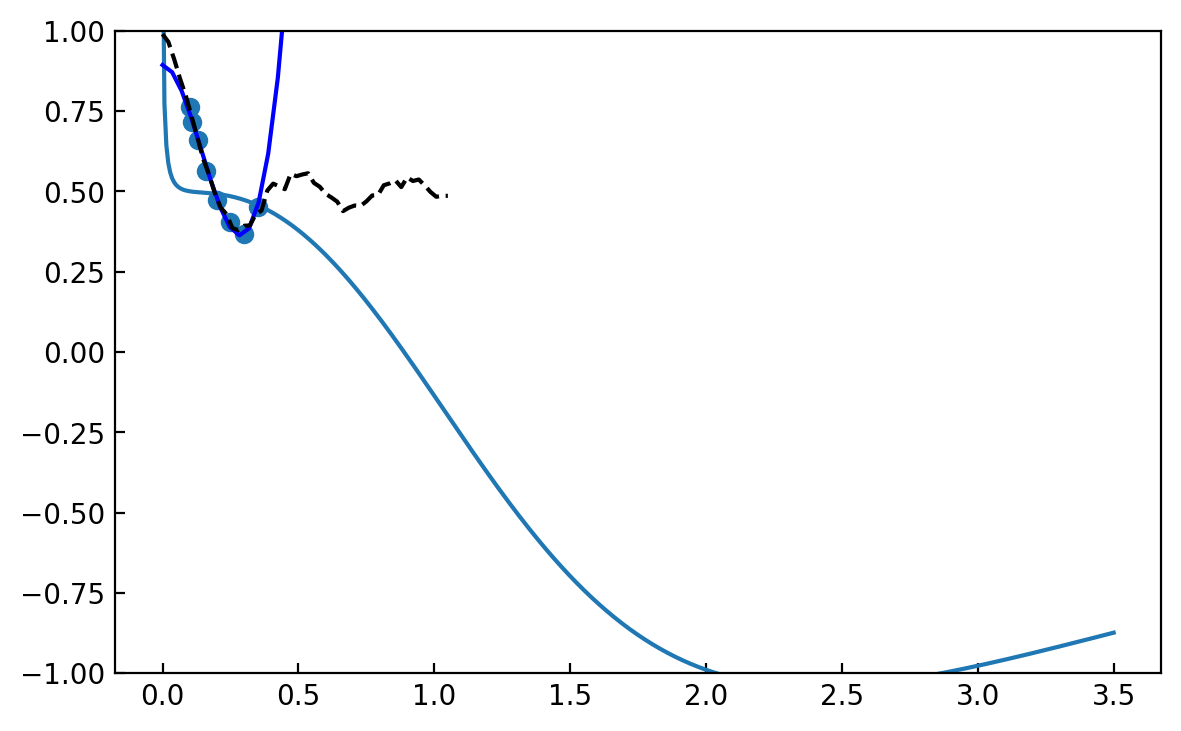

In [43]:

x = ZNE_points[1:]*baseline
y = ZNE_data[peak_index,1:]-0.5
plt.scatter(x, y+0.5)
max_order = 6
best_m, best_n, best_popt, best_error = optimize_pade_degree(x, y, max_order)
print(best_m, best_n)
print(best_popt)
x_fit = np.linspace(0, max(x)*10, 500)
m_coeff = best_popt[:best_m]
n_coeff = best_popt[best_m:]

#n_coeff = best_popt[:best_n+1]
print(n_coeff)
print(best_n)
#m_coeff = best_popt[best_n+1:]
print(m_coeff)
print(best_m)
y_fit = pade_approximant(x_fit, m_coeff, n_coeff) +0.5
plt.ylim(-1, 1)
plt.plot(x_fit, y_fit, label=f'Padé approximant (m={best_m}, n={best_n})')
plt.plot(ZNE_more_dense, function(ZNE_more_dense)+0.5, c='blue', label='Polynomial Fit')
plt.plot(ZNE_points_dense, dense_data[peak_index, :], c='k',ls='--', label='Exact')


#plt.plot(ZNE_more_dense, function(ZNE_more_dense)+0.5, c='blue', label='Polynomial Fit')
#plt.plot(ZNE_more_dense, p(ZNE_more_dense)/q(ZNE_more_dense)+0.5, c='red', label='Pade Fit')


# plt.plot(ZNE_points_dense, function(ZNE_points_dense), c='blue', label='Polynomial Fit')


